<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/playground_10_recurrent_light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение тональности отзывов на фильмы с сайта IMDB

* Замените полносвязную сеть на рекуррентную. Попробуйте три архитектуры сети:
    * SimpleRNN
    * GRU
    * LSTM
*  Используйте DropOut, чтобы снизить переобучение:
    * Попробуйте вставить слой SpatialDropout1D после слоя Embedding
    * Используйте параметры dropout и recurrent_dropout для рекуррентных слоев
* Меняйте архитектуру сети и гиперпараметры обучения, чтобы повысить качество распознавания тональности:
    * Измените длину вектора в слое Embedding
    * Изменяйте количество нейронов в рекуррентном слое
    * Попробуйте использовать двунаправленные рекуррентные слои (Bidirectional)
    * Попробуйте использовать несколько рекуррентных слоев в сети
    * Изменяйте размер мини-выборки для обучения
    * Попробуйте применить предварительно обученные векторы (GloVe, Word2Vec и т.п.)
* После подбора лучших гиперпараметров, обучите сеть еще раз на полном объеме данных без разделения на обучающий и проверочный наборы.

Составьте отчет, который включает:

* Место в соревновании, которое вам удалось достичь
* Описание архитектуры нейронной сети и гиперпараметров обучения
* Ссылку на ноутбук с кодом обучения
* График качества обучения на обучающем и проверочном наборах данных

# Подготовка окружения

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, SpatialDropout1D, SpatialDropout2D, LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import CuDNNGRU, CuDNNLSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
embedding_dim = 200
batch_size = 32
maxlen = 100
num_words=20000

## Загрузка данных с Kaggle

### Подключение Kaggle

In [0]:
file = files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Загрузка обучающего набора

In [0]:
!kaggle competitions download -c neural-university-imdb-spring2019
!unzip imdb_train.npz.zip
!unzip imdb_test.npy.zip

  0% 0.00/77.1k [00:00<?, ?B/s]
100% 77.1k/77.1k [00:00<00:00, 72.7MB/s]
  0% 0.00/3.31M [00:00<?, ?B/s]
100% 3.31M/3.31M [00:00<00:00, 54.2MB/s]
 38% 5.00M/13.3M [00:00<00:00, 29.9MB/s]
100% 13.3M/13.3M [00:00<00:00, 52.7MB/s]
Archive:  imdb_train.npz.zip
  inflating: imdb_train.npz          
Archive:  imdb_test.npy.zip
  inflating: imdb_test.npy           


## Загрузка наборов данных

In [0]:
# обучающий набор
data = np.load('imdb_train.npz') 
x_train = data['x'] 
y_train = data['y'] 

# тестовый набор
x_test = np.load('imdb_test.npy')

In [0]:
# IMDB from Keras for adjusting architecture
from keras.datasets import imdb

(ix_train, iy_train), (ix_test, iy_test) = imdb.load_data(path="imdb.npz")

lx_test = np.append(ix_train, ix_test)
ly_test = np.append(iy_train, iy_test)

lx_test = pad_sequences(lx_test, maxlen=maxlen)
# ix_test = pad_sequences(ix_test, maxlen=maxlen)

# print("Test on %s, %s" % (lx_test.shape, ly_test.shape))

## Подготовка данных для нейронной сети

In [0]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


In [0]:
print("Train on %s, %s" % (x_train.shape, y_train.shape))
print("Test on %s, %s" % (lx_test.shape, ly_test.shape))

Train on (40000, 100), (40000,)
Test on (50000, 100), (50000,)


In [0]:
# tmp_x_test = []
# tmp_y_test = []

# for i in range(len(lx_test)):
#     if (lx_test[i] not in x_train):
#         tmp_x_test.append(lx_test[i])
#         tmp_y_test.append(ly_test[i])
        
print(len(tmp_x_test))

0


## Загрузка векторных представлений

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2019-04-07 16:46:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-04-07 16:46:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  20.9MB/s    in 45s     

2019-04-07 16:46:58 (18.5 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
from keras.datasets import imdb
word_index = imdb.get_word_index()

In [0]:
embeddings_index = dict()
with open('glove.6B.%dd.txt' % embedding_dim, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        word_vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = word_vector
        
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words - 3:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i + 3] = embedding_vector

# Подготовка нейронной сети

In [0]:
def plot_training(acc, val_acc):
    plt.plot(acc, label='Train')
    plt.plot(val_acc, label='Val')
    plt.legend()
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 100, 200)          4000000   
_________________________________________________________________
spatial_dropout1d_31 (Spatia (None, 100, 200)          0         
_________________________________________________________________
cu_dnngru_23 (CuDNNGRU)      (None, 200)               241200    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 201       
Total params: 4,241,401
Trainable params: 241,401
Non-trainable params: 4,000,000
_________________________________________________________________
Train on 36000 samples, validate on 4000 samples
Epoch 1/2
36000/36000 [==============================] - 19s 520us/sample - loss: 0.5961 - acc: 0.6719 - val_loss: 0.4192 - val_acc: 0.8085
Epoch 2/2
36000/36000 [==============================] - 15s 418us/sa

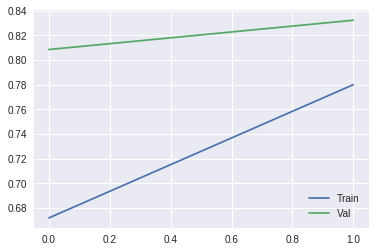

50000/50000 [==============================] - 15s 300us/sample - loss: 0.3750 - acc: 0.8335


[0.37498897178649904, 0.83354]

In [0]:
#del model

acc = []
val_acc = []

# Создание нейронной сети
model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.5))
model.add(CuDNNGRU(200))
model.add(Dense(1, activation='sigmoid'))

# Загрузка векторных представлений
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

# Сборка
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Обучение
history = model.fit(x_train, 
                    y_train, 
                    epochs=2,
                    batch_size=batch_size,
                    validation_split=0.1)

# График
acc.extend(history.history['acc'])
val_acc.extend(history.history['val_acc'])
plot_training(acc, val_acc)

# Оценка качества
model.evaluate(lx_test, ly_test, verbose = 1)

## Обучение с размороженными весами

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 100, 200)          4000000   
_________________________________________________________________
spatial_dropout1d_31 (Spatia (None, 100, 200)          0         
_________________________________________________________________
cu_dnngru_23 (CuDNNGRU)      (None, 200)               241200    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 201       
Total params: 4,241,401
Trainable params: 4,241,401
Non-trainable params: 0
_________________________________________________________________
Train on 36000 samples, validate on 4000 samples
Epoch 1/6
36000/36000 [==============================] - 13s 350us/sample - loss: 0.3807 - acc: 0.8272 - val_loss: 0.3027 - val_acc: 0.8650
Epoch 2/6
36000/36000 [==============================] - 11s 293us/sample -

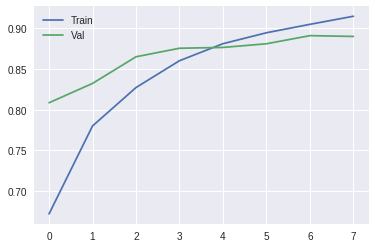

50000/50000 [==============================] - 27s 536us/sample - loss: 0.1867 - acc: 0.9265


[0.186725788718462, 0.92648]

In [0]:
model.layers[0].trainable = True

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

# Обучение
history = model.fit(x_train, 
                    y_train, 
                    epochs=6,
                    batch_size=batch_size,
                    validation_split=0.1)

# График
acc.extend(history.history['acc'])
val_acc.extend(history.history['val_acc'])
plot_training(acc, val_acc)

# Оценка качества
model.evaluate(lx_test, ly_test, verbose = 1)

## Дообучение SGD

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 100, 200)          4000000   
_________________________________________________________________
spatial_dropout1d_31 (Spatia (None, 100, 200)          0         
_________________________________________________________________
cu_dnngru_23 (CuDNNGRU)      (None, 200)               241200    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 201       
Total params: 4,241,401
Trainable params: 241,401
Non-trainable params: 4,000,000
_________________________________________________________________
Train on 36000 samples, validate on 4000 samples
Epoch 1/4
36000/36000 [==============================] - 97s 3ms/sample - loss: 0.1858 - acc: 0.9271 - val_loss: 0.2571 - val_acc: 0.8917
Epoch 2/4
36000/36000 [==============================] - 58s 2ms/sample

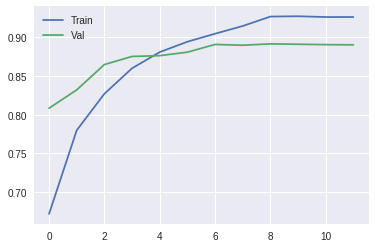

50000/50000 [==============================] - 23s 465us/sample - loss: 0.1849 - acc: 0.9282


[0.18488824370741844, 0.9282]

In [0]:
# model.layers[0].trainable = False

opt = SGD(lr=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

history = model.fit(x_train, 
                    y_train, 
                    epochs=4,
                    batch_size=16,
                    validation_split=0.1)

acc.extend(history.history['acc'])
val_acc.extend(history.history['val_acc'])
plot_training(acc, val_acc)

model.evaluate(lx_test, ly_test, verbose = 1)

In [0]:
plot_training(acc, val_acc)
model.evaluate(lx_test, ly_test, verbose = 1)


## Проверка на тестовом наборе

In [0]:
model.evaluate(lx_test, ly_test, verbose = 1)

50000/50000 [==============================] - 12s 241us/sample - loss: 0.1841 - acc: 0.9288


[0.1840726106572151, 0.9288]